In [4]:
#Importing libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

In [36]:
pd.options.display.float_format="{:,.2f}".format

In [6]:
#Loading the data
df=pd.read_csv("monthly_milk_production.csv",parse_dates=True , index_col="Date")
df.head()

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727


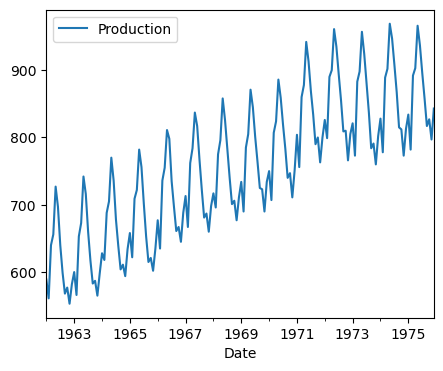

In [83]:
#Visualizing the data
df.plot(figsize=(5,4));

In [12]:
#Finding out the length of the dataframe

len(df)

168

In [13]:
#Setting up the length of the new datasets

test_size=12
test_ind=len(df) - test_size

train=df.iloc[:test_ind]
test=df.iloc[test_ind:]


In [14]:
train

,Production
Date,
1962-01-01,589
1962-02-01,561
1962-03-01,640
1962-04-01,656
1962-05-01,727
...,...
1974-08-01,867
1974-09-01,815
1974-10-01,812


In [15]:
test

,Production
Date,
1975-01-01,834
1975-02-01,782
1975-03-01,892
1975-04-01,903
1975-05-01,966
1975-06-01,937
1975-07-01,896
1975-08-01,858
1975-09-01,817


In [17]:
#Scaling the data
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()
scaler.fit(train)
scaled_train=scaler.transform(train)
scaled_test=scaler.transform(test)

In [19]:
#Creating the model

from keras.models import Sequential
from keras.layers import Dense,LSTM

length=12
n_features=1

model=Sequential()
model.add(LSTM(100,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam" , loss="mse")

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [70]:
#Creating the training and validation generators

from keras.preprocessing.sequence import TimeseriesGenerator

generator=TimeseriesGenerator(scaled_train,
                              scaled_train,
                              length=12,batch_size=1)


validation_generator=TimeseriesGenerator(scaled_test, 
                                         scaled_test,
                                         length=3,
                                         batch_size=1)


In [72]:
#Using EarlyStopping and fitting the model

from keras.callbacks import EarlyStopping

early_stop=EarlyStopping(monitor="val_loss" ,patience=3)

model.fit(generator,epochs=20,validation_data=validation_generator, callbacks=[early_stop])

Epoch 1/20
144/144 [==============================] - 2s 11ms/step - loss: 0.0031 - val_loss: 0.1256
Epoch 2/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0030 - val_loss: 0.1141
Epoch 3/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0028 - val_loss: 0.1194
Epoch 4/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.1138
Epoch 5/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0025 - val_loss: 0.1209
Epoch 6/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0023 - val_loss: 0.1281
Epoch 7/20
144/144 [==============================] - 1s 10ms/step - loss: 0.0021 - val_loss: 0.1267


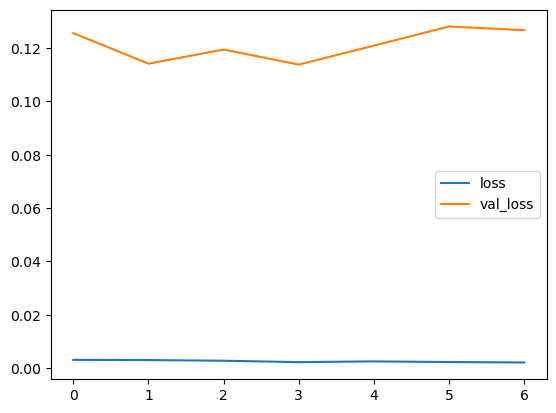

In [73]:
#Visualizing the losses

losses=pd.DataFrame(model.history.history)

losses.plot();

In [81]:
#Making test predictions using the train dataset

test_predictions=[]

length=12

first_eval_batch=scaled_train[-length:]

current_batch=first_eval_batch.reshape(1,length,n_features)

for i in range(len(test)):
    
  #get predicion 1 time stamp ahead( [0] is for grabbing just the number)
  current_pred=model.predict(current_batch,verbose=0)[0]

  #store prediction
  test_predictions.append(current_pred)

  #update batch to now include prediction and drop first value
  current_batch=np.append(current_batch[:,1:,:],[[current_pred]] ,axis=1)


In [82]:
#Creating a new dataframe to compare the predictions with the real data

true_predictions=scaler.inverse_transform(test_predictions)
new=pd.DataFrame(true_predictions,columns=["Predictions"])
new.index=test.index
comparison=pd.concat([test,new],axis=1)
comparison

,Production,Predictions
Date,,
1975-01-01,834,796.04
1975-02-01,782,801.40
1975-03-01,892,854.20
1975-04-01,903,890.03
1975-05-01,966,925.47
1975-06-01,937,917.88
1975-07-01,896,891.75
1975-08-01,858,852.51
1975-09-01,817,816.67


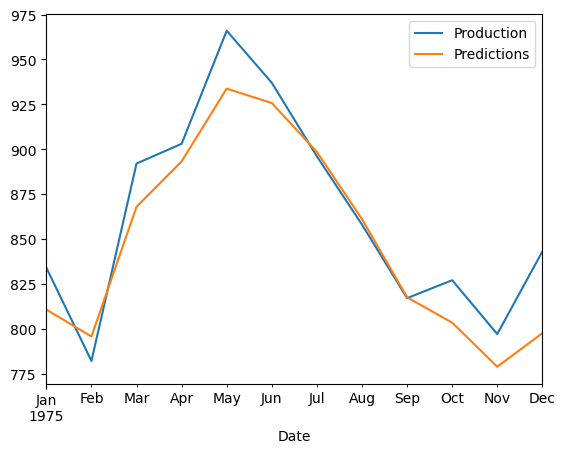

In [76]:
comparison.plot();

In [77]:
#Forecasting

full_scaler=MinMaxScaler()

scaled_full_data=full_scaler.fit_transform(df)

length=12

n_features=1

generator=TimeseriesGenerator(scaled_full_data,
                              scaled_full_data,
                              length=length,
                              batch_size=1)

model=Sequential()
model.add(LSTM(200,activation="relu",input_shape=(length,n_features)))
model.add(Dense(1))
model.compile(optimizer="adam" , loss="mse")
model.fit(generator,epochs=20)

Epoch 1/20
156/156 [==============================] - 4s 9ms/step - loss: 0.0380
Epoch 2/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0198
Epoch 3/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0141
Epoch 4/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0132
Epoch 5/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0076
Epoch 6/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0090
Epoch 7/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0055
Epoch 8/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0044
Epoch 9/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0048
Epoch 10/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0044
Epoch 11/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0049
Epoch 12/20
156/156 [==============================] - 1s 9ms/step - loss: 0.0057
Epoch 13/20
156/156 [====

In [78]:
#Obtaining the forecast

forecast=[]

periods=12

first_eval_batch=scaled_full_data[-length:]

current_batch=first_eval_batch.reshape(1,length,n_features)

for i in range(periods):
    
  current_pred=model.predict(current_batch,verbose=0)[0]

  forecast.append(current_pred)

  current_batch=np.append(current_batch[:,1:,:],[[current_pred]] ,axis=1)

In [63]:
#Using inverse_transform y the forecast and creating and index for making it a DataFrame

forecast=full_scaler.inverse_transform(forecast)

forecast_index=pd.date_range(start="1976-01-01",periods=periods,freq="MS")

forecast_df=pd.DataFrame(data=forecast,
                         index=forecast_index,
                         columns=["Forecast"])

forecast_df

,Forecast
1976-01-01,818.51
1976-02-01,814.80
1976-03-01,871.25
1976-04-01,903.00
1976-05-01,940.11
1976-06-01,925.17
1976-07-01,893.16
1976-08-01,855.74
1976-09-01,829.23
1976-10-01,821.29


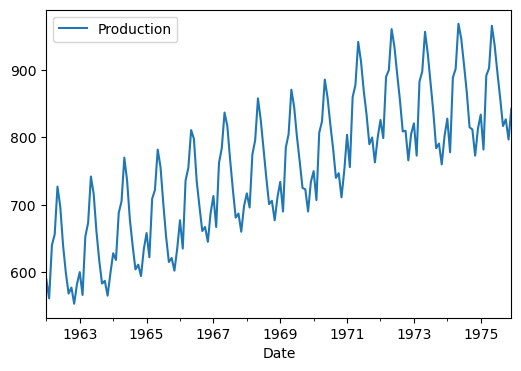

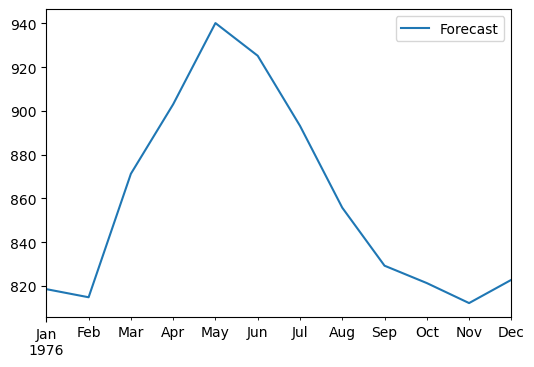

In [79]:
#Plotting the result in different graphics

df.plot(figsize=(6,4));

forecast_df.plot(figsize=(6,4));

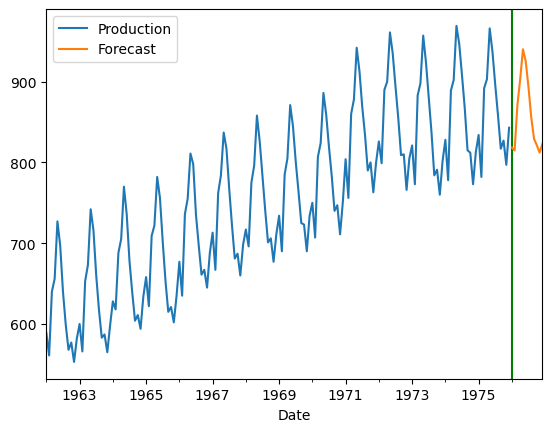

<Figure size 1500x1000 with 0 Axes>

In [84]:
#Plotting the result in the same graphic
ax=df.plot();
plt.axvline("1976-01-01",c="g");
forecast_df.plot(ax=ax);
plt.figure(figsize=(15,10));